In [7]:
pip install torch torchvision


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\navee\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [8]:
pip install scikit-image

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB 1.4 MB/s eta 0:00:10
   ---------------------------------------- 0.1/12.9 MB 1.4 MB/s eta 0:00:09
   - -------------------------------------- 0.3/12.9 MB 2.6 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/12.9 MB 4.5 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/12.9 MB 6.1 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/12.9 MB 6.5 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/12.9 MB 6.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.9/12.9 MB 8.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.9/12.9 MB 8.4 MB/s eta 0:00:02
   ------------ --------------------------- 4.0/12.9 MB 9.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.6/12.9 MB 9.4 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\navee\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from skimage import exposure

In [4]:
import cv2
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

In [ ]:
class SonarDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], 0)  # Reading in grayscale
        mask = cv2.imread(self.mask_paths[idx], 0)

        # Apply histogram equalization for contrast enhancement
        img = exposure.equalize_adapthist(img)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

# Data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# U-Net Architecture with Attention Mechanism
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(torch.relu(g1 + x1))
        return x * psi

class UNetWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithAttention, self).__init__()

        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ConvBlock(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.decoder4 = ConvBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.decoder3 = ConvBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.decoder2 = ConvBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder path
        d4 = self.upconv4(b)
        e4 = self.att4(g=d4, x=e4)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(g=d3, x=e3)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(g=d2, x=e2)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        return self.final_conv(d1)

# Loss Function and Optimizer
def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Model training function
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in dataloader:
            images = images.float().cuda()
            masks = masks.float().cuda()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Model, Loss, OptimizerC:\Users\navee\OneDrive\Desktop\Minor-3\Side Scan Sonar\train\images\ship-009_png.rf.3a1f48e60491254df609bd7b0bfeb9f5.jpg
model = UNetWithAttention(in_channels=1, out_channels=1).cuda()
criterion = dice_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load dataset
train_dataset = SonarDataset(image_paths=['path_to_images'], mask_paths=['path_to_masks'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=50)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

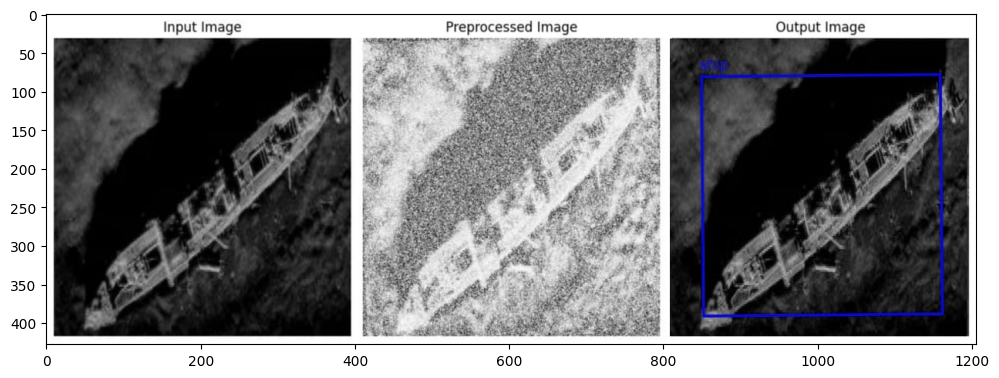

In [7]:
import cv2
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Load the images
image1_path = 'C:/Users/navee/OneDrive/Desktop/Minor-3/CN.jpg'

image1 = cv2.imread(image1_path)

# Check if the images were loaded successfully
if image1 is None:
    print(f"Error: Unable to load image file '{image1_path}'")
    exit()
if image2 is None:
    print(f"Error: Unable to load image file '{image2_path}'")
    exit()

# Get the height and width of the images
height1, width1, _ = image1.shape

# Resize the images to the same height if necessary
if height1 != height2:
    scale = height1 / height2
    image2 = cv2.resize(image2, (int(width2 * scale), height1))

# Create a horizontal stack of the images
stacked_image = np.hstack((image1, image2))

# Convert the stacked image to RGB format
stacked_image = cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Display the input image
plt.imshow(image1)
plt.set_title('')
plt.axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()